## Implemenation of A Collaborative Filtering System for Movie Recommendaion

This project implemented a model-based collaborative filtering recommendation system using gradient descendent optimization, and applied this system to movie recommendation using the MovieLens datset, whcih can be downloaded [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip). A brief description of the dataset is available [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt). 

### Load packages and data

In [127]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from scipy import optimize

In [128]:
column_names=['user_id','item_id','rating','timestamp']
df=pd.read_csv('u.data',sep='\t',names=column_names)

Let's take a quick look at the data

In [129]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


The item_id in this dataset corresponds to the id of movies. Titles of movies can be obtained by loading the Movie_ID_Titles file, and merging the movie_title dataframe with the current dataframe, as shown below:

In [130]:
movie_title=pd.read_csv("Movie_ID_Titles")
pd.merge(df,movie_title,on='item_id').head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


For collaborative filtering system to predict the movie ratings, however, we do not need movie titles. In fact, the recommendation system only needs user_id, item_id and rating columns. Therefore, we will modify the df dataframe to only include these columns.

In [131]:
df=df.iloc[:,:3]
df.head()

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


### Data Exploration
Now let's explore the dataset a little bit.
First, how many of unique movies and users are included?

In [132]:
print "number of unique movies is: ",len(df['item_id'].unique())
print "number of unique users is: ",len(df['user_id'].unique())

number of unique movies is:  1682
number of unique users is:  944


rating is the rate that users gave to movies, and is a number between 1 and 5. Let's see the distribution of ratings

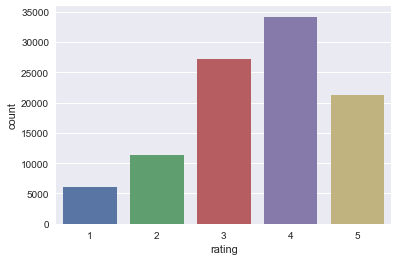

In [133]:
sns.countplot(df['rating'])

This gives us the general idea of the distribution of the ratings over all the movies. Now let's see the distribution of the average rating based on each movie:

In [134]:
rating=pd.DataFrame({'ave_rating':df.groupby('item_id')['rating'].mean()})
rating['number_of_ratings']=df.groupby('item_id')['rating'].count()

In [135]:
rating.head()

,ave_rating,number_of_ratings
item_id,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86


In [136]:
type(rating)

pandas.core.frame.DataFrame

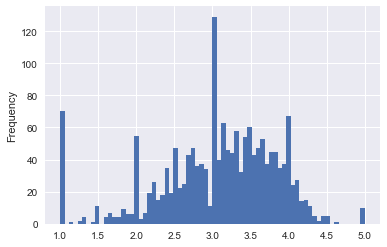

In [137]:
rating['ave_rating'].plot.hist(bins=70)

From this figure, we observed a "bell-shaped" distribution of the average rating based on each movie. Then the question is: is there any correlation between the average rating and the number of rates for a moive?

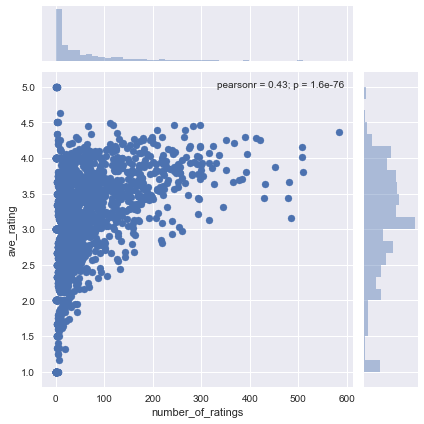

In [183]:
sns.jointplot('number_of_ratings','ave_rating',rating)

We observe a large number of movies with number of ratings less than 200. Basically, there is no apparent trend in the average ratings versus the number of ratings.

### Data Transformation
In this project, we will build a collaborative filtering system by fractoring the user-movie rating matrix (data matrix) to the product of two low rank matrices. The data matrix consists of the ratings of movies given by users. Since most of the users did not watch all of the movies, the data matrix usually is a sparse matrix containing many missing values. By optimizing the parameters of the two low rank matrices, we would expect to use the product of these two matrices to approximate the data matrix. Furthermore, the product of these two matrices will give the predictions to missing values in the original data matix, based on which, we can give the recommendations to users. Therefore, the first step of implementing the collaborative filtering system is to transform the raw data to a data matrix, where each row corresponds to each movie, and each column corresponds to one user. We tranform the data using pandas pivot function

In [184]:
rate_mat=df.pivot(index='item_id',columns='user_id',values='rating')

In [185]:
rate_mat.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
item_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
rate_mat.shape

(1682, 944)

In the rate_mat dataframe, each row corresponds to one movie, and each column corresponds to a user. There are 944 columns in the dataset, corresponding to 944 users and 1682 rows, corresponding to 1682 movies. In addition, as mentioned before, this matrix is a sparse matrix: There are many missing values in the dataframe. We will fill these missing values by 0, since a valid rating should between 1 and 5. So it is perfect to use 0 to represent missing values here.

In [187]:
rate_mat.fillna(0,inplace=True)

We then observed that all the values in the first columns are zero, which will not provide useful information for the recommendation system. Therefore, this column was eliminated, and we have 943 "valid" users.

In [188]:
rate_mat=rate_mat.loc[:,1:]

In [189]:
rate_mat.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
item_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
rate_mat=rate_mat.values

In addition to the rate_mat, we also define another matrix, valid_rate that defines whether or not a user rated a movie. If the ith user gave a valid rating to the jth movie, then valid_rate[j,i]=1, otherwise, valid_rate[j,i]=0.

In [196]:
valid_rate=np.ones(rate_mat.shape)

In [197]:
valid_rate[rate_mat<1.0]=0.0

In [199]:
rate_mat[:5,:5]

array([[ 5.,  4.,  0.,  0.,  4.],
       [ 3.,  0.,  0.,  0.,  3.],
       [ 4.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.]])

In [200]:
valid_rate[:5,:5]

array([[ 1.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]])

### Factorizing Rating Matrix to Low Rank Matrices
Next, we will factorizing the ratings matrix to two low rank matrices. To make it simple, we will factorize the rate_mat into two matrice: one is the X_prod matrix, consisting of 1682 rows and 10 columns, and the other is the Theta_user matrics, consisting of 10 rows and 943 columns. You can imagine that each row in X_prod matrix is the feature vector that characterizes the corresponding movie. For example, if a movie is a romance movie, the value corresponding to romance in its feature vector will be high. We assume that there are 10 of such important features that will decide the ratings of a movie. Similarly, in Theta_user matrix, each column defines the perference of one specific user to the 10 moive features. For example, if a user likes a romance movie, the corresponding value in its Theta_user column will have a high value. Finally, the rating of a user to a moive is the inner product of the corresponding Theta_user column and the X_prod row. For example, rating of the ith user for jth moive is the inner product of the jth row of X_prod and the ith column of Theta_users. Based on this concept, we implemented the collaborative filtering recommendation system below. The basic idea is to optimize parameters in X_prod and Theta_user matrices to make their product as close to rate_mat matrix as possible. We calculated the cost function based on the sum of squared residual between rate_mat and product of X_movie and Theta_user. In addition, we calculated the gradient of one of the X_prod and Theta_user by assuming the other matrix as a constant matrix. We then updated the gradient of X_prod and Theta_user alternatively, until finally their product is close enough to rate_mat. For the detailed analysis of the algorithm, including the derivation of the equations and theory, please refer to [my github project for Recommendation System](http://htmlpreview.github.io/?https://github.com/yuanDataScience/Machine_Learning_R/blob/master/RecommendationSystems/RecommendationSystems.nb.html) 

In [201]:
from sklearn.base import BaseEstimator, ClassifierMixin
class Recommend(BaseEstimator, ClassifierMixin):
    def __init__(self,num_features=10,lmd=0):
        self.num_features=num_features
        self.lmd=lmd
        
          
    def _costCompute(self,theta,valid_rate,rate_mat):
        num_prod=rate_mat.shape[0]
        num_user=rate_mat.shape[1]
                
        X_prod_len=self.num_features*num_prod
        Theta_user_len=self.num_features*num_user
        
        X_prod=theta[:X_prod_len].reshape((num_prod,self.num_features)) #1682*10
       
        Theta_user=theta[X_prod_len:].reshape((self.num_features,num_user))#10*934
        
        diff=(((rate_mat-X_prod.dot(Theta_user))**2)*valid_rate).sum()
        l2=self.lmd*((X_prod**2).sum()+(Theta_user**2).sum())
                
        return 0.5*(diff+l2)    
    
    def _gradCompute(self,theta,valid_rate,rate_mat):
        num_prod=rate_mat.shape[0]
        num_user=rate_mat.shape[1]
                
        X_prod_len=self.num_features*num_prod
        Theta_user_len=self.num_features*num_user
        
        X_prod=theta[:X_prod_len].reshape((num_prod,self.num_features)) # 1682*10
       
        Theta_user=theta[X_prod_len:].reshape((self.num_features,num_user)) #10*944
        diff=(X_prod.dot(Theta_user)-rate_mat)*valid_rate #1682*944
        
        grad_X_prod=diff.dot(Theta_user.T)+self.lmd*X_prod
        grad_Theta_user=X_prod.T.dot(diff)+self.lmd*Theta_user
        
        return np.concatenate((grad_X_prod.ravel(),grad_Theta_user.ravel()))
    
    def _gradNumericCompute(self,theta,valid_rate,rate_mat):
        para_size=len(theta)
        disturb=np.zeros(para_size)
        numgrad=np.zeros(para_size)
        
        e=1e-4
        for i in range(para_size):
            disturb[i]=e
            
            loss1=self._costCompute(theta+disturb,valid_rate,rate_mat)
            loss2=self._costCompute(theta-disturb,valid_rate,rate_mat)
            
            numgrad[i]=(loss1-loss2)/(2*e)
            disturb[i]=0
        
        return numgrad
    
    def checkCostFunction(self,lmd=0):
        num_prod=4
        num_user=5
        self.num_features=3
        self.lmd=lmd
        X_t=np.random.uniform(size=12).reshape((num_prod,self.num_features))
        Theta_t=np.random.uniform(size=15).reshape((self.num_features,num_user))
        
        y_t=X_t.dot(Theta_t)
        
        R=np.zeros(y_t.shape)
        random_y=np.random.uniform(size=num_prod*num_user).reshape(y_t.shape)
        y_t[random_y>0.5]=0
        R[y_t!=0]=1
        
        params=np.random.uniform(size=(num_prod+num_user)*self.num_features)
        num_grad=self._gradNumericCompute(params,R,y_t)
        cal_grad=self._gradCompute(params,R,y_t)
        
        diff_vec=num_grad-cal_grad
        total_vec=num_grad+cal_grad
        
        diff=(diff_vec**2).sum()/(total_vec**2).sum()
        print "normalized difference is: ", diff
        
        return pd.DataFrame({'num_grad':num_grad,'cal_grad':cal_grad})
    
    def _normalize(self,valid_rate,rate_mat):
        Y_rated=rate_mat*valid_rate
        Y_mean=Y_rated.sum(axis=1)/valid_rate.sum(axis=1)
        Y_mean=Y_mean.reshape((rate_mat.shape[0],1))
        Y_mean=np.repeat(Y_mean,rate_mat.shape[1],axis=1)
         
        Y_norm=(rate_mat-Y_mean)*valid_rate
        self.Y_mean=Y_mean
        return Y_norm
        
    def fit(self,valid_rate,rate_mat):
        
        Y_norm=self._normalize(valid_rate,rate_mat)
        
        num_prod=rate_mat.shape[0]
        num_user=rate_mat.shape[1]
        
        X_t=np.random.uniform(size=num_prod*self.num_features).reshape((num_prod,self.num_features))
        Theta_t=np.random.uniform(size=self.num_features*num_user).reshape((self.num_features,num_user))
        
        theta=np.concatenate((X_t.ravel(),Theta_t.ravel()))        
        rs=optimize.minimize(fun=self._costCompute, x0=theta, args=(valid_rate,Y_norm),method='CG',jac=self._gradCompute)
        print rs.message
        if rs.success:
            print "successful"
            theta_opt=rs.x
            self.X_t=theta_opt[:num_prod*self.num_features].reshape((num_prod,self.num_features))
            self.Theta_t=theta_opt[num_prod*self.num_features:].reshape((self.num_features,num_user))
        return self  
    
    def predict(self):
        return self.X_t.dot(self.Theta_t)+self.Y_mean
       
    

Before we train the recommendation system, we first check if the _gradCompute() function is properly implemented using checkCostFunction(). This function builds a small user-item rating table. The rating values are generated from two low rank tables corresponding to the product and user features, with 3 features. In addition, to mimic the real recommendation system scenario, some of the rating values were eliminated. The function then use the simulted rating and valid_rating table to calculate the gradient of user and product feature parameters by both numerical method and the method based on the first derivatives of cost function versus product and user features.   

In [202]:
rd=Recommend()

In [203]:
rd.checkCostFunction(lmd=3)

normalized difference is:  5.13236623668e-24


,cal_grad,num_grad
0,1.506427,1.506427
1,2.066171,2.066171
2,1.623511,1.623511
3,2.158853,2.158853
4,0.903042,0.903042
5,2.543855,2.543855
6,0.852476,0.852476
7,1.657400,1.657400
8,0.991053,0.991053
9,1.126821,1.126821


From the comparison of the result of checkCostFunction(), we can see that the normalized difference in the results obtained by the two methods is very small. In addition, comparing the gradient vectors calculated by the two methods shows that the two gradient vectors are very close to each other element-wise. Therefore, we are confident that the gradient function is implemented correctly.

In addition, I would like to check if the recommendation system could recommend me movies according to ratings I gave to some movies. The list of my ratings is the following, which contains my ratings to 11 movies: 

In [153]:
#build the myrating list
my_ratings=np.zeros(rate_mat.shape[0]).reshape((rate_mat.shape[0],1))
my_valid_ratings=np.zeros(rate_mat.shape[0]).reshape((rate_mat.shape[0],1))
#test and demonstrate the my_rating list
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

my_valid_ratings[0]=1
my_valid_ratings[97] = 1
my_valid_ratings[6] = 1
my_valid_ratings[11]= 1
my_valid_ratings[53] = 1
my_valid_ratings[63]= 1
my_valid_ratings[65]= 1
my_valid_ratings[68] = 1
my_valid_ratings[182] = 1
my_valid_ratings[225] = 1
my_valid_ratings[354]= 1

for i in range(len(my_ratings)):
    if (my_ratings[i] > 0):
        print "rating for ",movie_title.loc[i,'title'],"is ",my_ratings[i,0],"\n" 
  

rating for  Toy Story (1995) is  4.0 

rating for  Twelve Monkeys (1995) is  3.0 

rating for  Usual Suspects, The (1995) is  5.0 

rating for  Outbreak (1995) is  4.0 

rating for  Shawshank Redemption, The (1994) is  5.0 

rating for  While You Were Sleeping (1995) is  3.0 

rating for  Forrest Gump (1994) is  5.0 

rating for  Silence of the Lambs, The (1991) is  2.0 

rating for  Alien (1979) is  4.0 

rating for  Die Hard 2 (1990) is  5.0 

rating for  Sphere (1998) is  5.0 



Now, I will add my ratings to rate_mat table, and update the corresponding column in valid_rate matrix. To make sure I can find my ratings, I will put my rating as the first column in rate_mat table.

In [204]:
rate_mat=np.hstack((my_ratings,rate_mat))
valid_rate=np.hstack((my_valid_ratings,valid_rate))

In [205]:
rd1=Recommend(lmd=10)

In [157]:
rd1.fit(valid_rate,rate_mat)
pred_mat=rd1.predict()

Optimization terminated successfully.
successful


Now, I will retrieve the first column of the rating table predicted by the recommendation system, which contains ratings of 1682 movies that recommendation system predicted based on the 11 movie ratings I gave before. I will sort the movies according to the predicted ratings by putting high rating movies on the top of the list, and print the top 15 movies that the system recommended to me.

In [181]:
top_movie=np.argsort(pred_mat[:,1])[::-1][:15]

In [182]:
for idx in top_movie:
    rate=my_movie_pred[idx]
    title=movie_title.loc[idx,'title']
    print 'predicting rating %d for %s' %(rate,title)

predicting rating 5 for Star Wars (1977)
predicting rating 5 for Empire Strikes Back, The (1980)
predicting rating 5 for Return of the Jedi (1983)
predicting rating 5 for Monty Python and the Holy Grail (1974)
predicting rating 5 for Lawrence of Arabia (1962)
predicting rating 5 for Wrong Trousers, The (1993)
predicting rating 5 for Fargo (1996)
predicting rating 5 for Citizen Kane (1941)
predicting rating 5 for Santa with Muscles (1996)
predicting rating 5 for Prefontaine (1997)
predicting rating 5 for Great Day in Harlem, A (1994)
predicting rating 5 for Aiqing wansui (1994)
predicting rating 4 for Star Kid (1997)
predicting rating 4 for Entertaining Angels: The Dorothy Day Story (1996)
predicting rating 4 for Marlene Dietrich: Shadow and Light (1996) 


Now I obtained the top 15 recommended movies!